# Compressed screen simulation

In [273]:
import numpy as np
from scipy.optimize import minimize, nnls, LinearConstraint, lsq_linear
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import einops

import scipy.sparse as sparse

### Define the experiment parameters

In [274]:
num_markers = 10
num_measurements = 4
num_perturb = 10
num_bins = 3
num_cells = int(1e4)
seq_depth = 100000

gates_min = np.array([-np.inf, -0.6, 0.6])
gates_max = np.array([-0.6, 0.6, np.inf])
bin_code = np.array([-1,0,1])

### Define the ground truth variables

- `D`: True effect size of each guide on expression, `num_perturb x num_markers`
- `S`: Guide assignment for single cells, `num_cells x num_perturb`

In [275]:
D = stats.norm.rvs(size=(num_perturb, num_markers))
D[np.absolute(D) < 1.5] = 0
S = np.zeros((num_cells, num_perturb))
for row in range(num_cells):
    S[row, np.random.randint(num_perturb)]=1
print('Sanity check, guide assignment per cell', S.sum(axis=1))

Sanity check, guide assignment per cell [1. 1. 1. ... 1. 1. 1.]


### Generate single cells

Single cell expression

In [276]:
Z = stats.norm.rvs(S@D)

<AxesSubplot:ylabel='Density'>

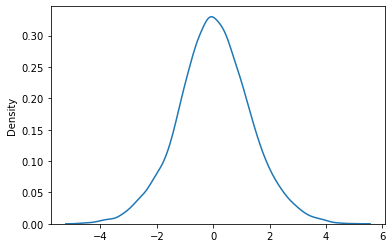

In [277]:
sns.kdeplot(Z[:, 0])

### Sort and sequence for "vanilla" screen

In [278]:
num_cells_per_measurement = int(num_cells/num_markers)

S_list = np.array_split(S, num_markers)
Z_list = np.array_split(Z, num_markers)

In [279]:
Y_vanilla = np.zeros((num_markers, num_bins, num_perturb))
X_vanilla = np.zeros((num_markers, num_bins))
for i in range(num_markers):
    
    for b in range(num_bins):
        
        X_vanilla[i, b] = bin_code[b]
        for g in range(num_perturb):
            
            guide_count = 0
            cell_count = 0
            
            for cell in range(num_cells_per_measurement):
                
                if Z_list[i][cell, i] > gates_min[b] and Z_list[i][cell, i] < gates_max[b]:
                    
                    guide_count += S_list[i][cell, g]
                    cell_count += 1
            Y_vanilla[i, b, g] = guide_count/cell_count
                    

### Solve vanilla case

In [280]:
def vanilla_fn(beta):
    
    beta = beta.reshape(num_markers, num_perturb)
    loss = 0
    for i in range(num_markers):
        for g in range(num_perturb):
            
            y = np.log(Y_vanilla[i, :, g]+1e-3)
            x = bin_code
            loss += ((y-beta[i, g]*x)**2).sum()
    return loss

In [281]:
res = minimize(fun=vanilla_fn, x0=stats.norm.rvs(size=num_markers*num_perturb))
D_hat_vanilla = res.x.reshape(num_markers, num_perturb)

Text(0.5, 0, 'Actual effect of guide on expression')

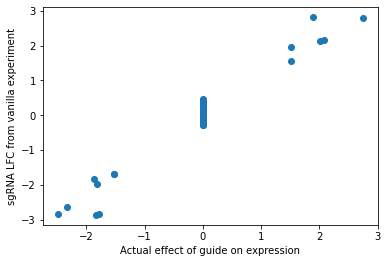

In [282]:
plt.scatter(D.T.ravel(),D_hat_vanilla.ravel())
plt.ylabel('sgRNA LFC from vanilla experiment')
plt.xlabel('Actual effect of guide on expression')


### Sort and sequence the "pooled" screen

In [289]:
num_markers_per_pool = 7
pooling_matrix = np.zeros((num_markers, num_measurements))
for idx in range(num_measurements):
    pooling_matrix[np.random.choice(num_markers, size=num_markers_per_pool, replace=False), idx] = 1
    

<AxesSubplot:ylabel='Density'>

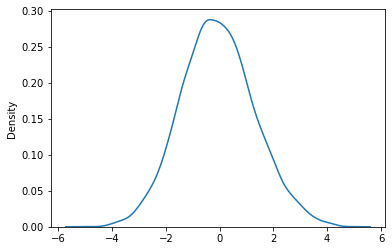

In [290]:
num_cells_per_measurement = int(num_cells/num_measurements)

S_list = np.array_split(S, num_measurements)

Zp = Z@pooling_matrix/np.sqrt(num_markers_per_pool)
Zp_list = np.array_split(Zp, num_measurements)
sns.kdeplot(Zp[:, 0])

In [291]:
Y_pooled = np.zeros((num_measurements, num_bins, num_perturb))
for i in range(num_measurements):
    
    for b in range(num_bins):
        
        for g in range(num_perturb):
            
            guide_count = 0
            cell_count = 0
            
            for cell in range(num_cells_per_measurement):
                
                if Zp_list[i][cell, i] > gates_min[b] and Zp_list[i][cell, i] < gates_max[b]:
                    
                    guide_count += S_list[i][cell, g]
                    cell_count += 1
            Y_pooled[i, b, g] = guide_count/cell_count
                    

### Solve pooled screen

In [292]:
def pooled_fn(beta):
    
    beta = beta.reshape(num_markers, num_perturb)
    beta_pool = pooling_matrix.T.dot(beta)
    
    loss = 0
    
    for i in range(num_measurements):
        for g in range(num_perturb):
            
            y = np.log(Y_pooled[i, :, g]+1e-3)
            x = bin_code
            loss += ((y-beta_pool[i, g]*x)**2).sum()/num_bins
    penalty = np.linalg.norm(beta, ord=1)
    return loss + alpha * penalty

In [293]:
alpha=10
res = minimize(fun=pooled_fn, x0=stats.norm.rvs(size=num_markers*num_perturb))
D_hat_pooled = res.x.reshape(num_markers, num_perturb)

Text(0, 0.5, 'sgRNA LFC from pooled experiment')

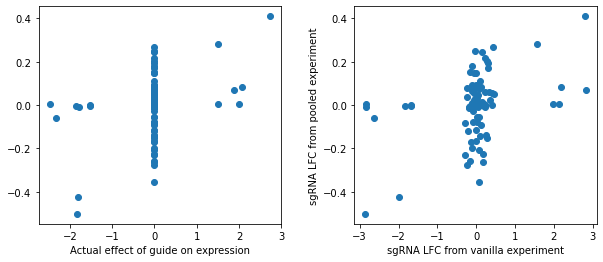

In [294]:
plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 2, 1)
plt.scatter(D.T.ravel(), D_hat_pooled.ravel())
plt.xlabel('Actual effect of guide on expression')
plt.subplot(1, 2, 2)
plt.scatter(D_hat_vanilla.ravel(),D_hat_pooled.ravel())
plt.xlabel('sgRNA LFC from vanilla experiment')
plt.ylabel('sgRNA LFC from pooled experiment')


### Analyize vanilla screen

In [ ]:
Y_vanilla_flat = einops.rearrange(Y_vanilla, 'i j k -> (i j) k')
X_vanilla = 

In [157]:
Y_vanilla.shape

(15, 2, 100)

In [158]:
Y_pooled.shape

(5, 2, 100)

array([[0.00234742, 0.00234742, 0.00704225, ..., 0.00704225, 0.00469484,
        0.01877934],
       [0.00422833, 0.00634249, 0.00211416, ..., 0.01691332, 0.01057082,
        0.01268499],
       [0.0022779 , 0.00455581, 0.02050114, ..., 0.01138952, 0.01594533,
        0.00455581],
       ...,
       [0.        , 0.02455357, 0.01785714, ..., 0.00223214, 0.00892857,
        0.00223214],
       [0.02136752, 0.01282051, 0.        , ..., 0.01709402, 0.00854701,
        0.01709402],
       [0.        , 0.        , 0.02137767, ..., 0.0023753 , 0.00475059,
        0.00950119]])